In [1]:
import torch
import torch.nn as nn
from pyhessian import hessian
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import scipy as sp

epochs = 10000
n_tasks = 1
L = 0
gamma0 = 1
widths = [512,512,512,512,512]
device = 'mps'
gen = torch.Generator(device=device)
gen.manual_seed(123)
batch = 100

class MLP(nn.Module):
            def __init__(self, w, L, param, gam):
                super(MLP, self).__init__()
                self.w = w
                if param =='ntk':
                    self.gamma = gam
                    self.in_scale = 784**0.5
                    self.out_scale = self.w**0.5*self.gamma
                elif param == 'mup': 
                     self.gamma = gam*self.w**0.5
                     self.in_scale = 784**0.5
                     self.out_scale = self.w**0.5*self.gamma
                elif param == 'sp':
                     self.gamma = 1
                     self.in_scale = 1
                     self.out_scale = 1

                self.fc1 = nn.Linear(784, self.w, bias=False)
                self.fc2 = nn.Linear(self.w, 1, bias=False)
                self.relu = nn.ReLU()
                self.L = L

            def forward(self, x):
                h1 = self.fc1(x)/self.in_scale
                h1act = self.relu(h1)
                h2 = self.fc2(h1act)/self.out_scale

                return h2
            
@torch.no_grad()
def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.normal_()

def permut_row(x, perm):
            return x[perm]

        # ---------------------- START DATA -------------------------
data = pd.read_csv('~/data/MNIST/mnist_train.csv')
test = pd.read_csv('~/data/MNIST/mnist_test.csv')
data = data[data['label'].isin([0, 1])]
test = test[test['label'].isin([0, 1])]
X = torch.tensor(data.drop('label', axis = 1).to_numpy(), device=device)/255
X_test = torch.tensor(test.drop('label', axis = 1).to_numpy(), device=device)/255
X = X[:batch]

Y_temp = torch.tensor(data['label'].to_numpy(), device=device)
Y = torch.eye(1, device=device)[Y_temp]
Y = Y[:batch]

Y_temp = torch.tensor(test['label'].to_numpy(), device=device)
Y_test = torch.eye(10, device=device)[Y_temp]

tasks = [X]
tasks_test = [X_test]

for _ in range(n_tasks):
        perm = np.random.permutation(X.shape[1])
        tasks.append( torch.tensor(np.apply_along_axis(permut_row, axis = 1, arr=X.cpu(), perm=perm)).to(device) )
        tasks_test.append(torch.tensor(np.apply_along_axis(permut_row, axis = 1, arr=X_test.cpu(), perm=perm)).to(device))


def top_eigen(model, loss, X, Y, prt=False):

            hess_comp = hessian(model, loss, (X,Y) )
            top_eigenvalues, top_eigenvector = hess_comp.eigenvalues()
                
            return top_eigenvalues[-1] , top_eigenvector

def overlap(model, inputs, targets):
    
    gradients = torch.cat([param.grad.view(-1) for param in model.parameters()])
    params = torch.cat([param.data.view(-1) for param in model.parameters()])

    norm = torch.norm(params)

    def loss_fn(params):
        idx = 0
        layers = []
        for param in model.parameters():
            param_numel = param.numel()
            layers.append(params[idx:idx + param_numel].view_as(param))
            idx += param_numel
        relu = nn.ReLU()
        outputs = relu(inputs@layers[0].T) @ layers[1].T
        return MSE(outputs, targets)

    hvp = torch.autograd.functional.hvp(loss_fn, params, gradients)[1]
    return (torch.dot(hvp,gradients)/(torch.norm(hvp) * torch.norm(gradients))).item(), norm.item()


In [2]:
save_out = False

res1 = np.zeros((epochs*2,len(X)))
res2 = np.zeros((epochs*2,len(X)))

for regime in ['ntk']:
    for N in widths:

        loss_hist = []
        lam = []
        acc = []
        all = []
        res1t = []
        res2t = []
        norm = []
        
        mlp = MLP(N,L,regime, gamma0)
        lrs = {'sp':1,'ntk':1,'mup': mlp.gamma**2}
        lr = lrs.get(regime)

        if regime == 'ntk' or regime == 'mup':
            mlp = mlp.apply(init_weights)
            
        summary(mlp, (1,784))
        mlp = mlp.to(device)
        
        optimizer = torch.optim.SGD(mlp.parameters(), lr= lr )
        eos = 2/lr
     
        MSE = nn.MSELoss()

        for t,Xt in enumerate(tasks):        
                for epoch in range(epochs):

                        running_loss = 0.0
                        for i in range(len(Xt)//batch):

                            # Batch of training 
                            ix = torch.randint(0, len(X), (batch,), generator=gen, device=device)

                            #ixc = torch.randint(0, len(X), (1024,), generator=gen, device=device)

                            #lt = []
                            #for s in range(t+1):
                            #    sharp, eigen = top_eigen(mlp, MSE, tasks[s][ixc], Y[ixc])
                            #    lt.append(sharp)
                            #lam.append(lt)    

                            optimizer.zero_grad()

                            out = mlp(Xt[ix])
                            loss = MSE(out, Y[ix])

                            res1t.append( list((torch.sum(mlp(tasks[0][ix]) - Y[ix], dim=1)).detach().cpu()) )
                            res2t.append( list((torch.sum(mlp(tasks[1][ix]) - Y[ix], dim=1)).detach().cpu()) )
                            
                            loss.backward()
                            running_loss += loss.item()

                            #over, no = overlap(mlp, X[ix], Y[ix])

                            #all.append(over)
                            #norm.append(no)
                            
                            optimizer.step()
                            loss_hist.append(loss.item())

                            #print(f'task {t} : (epoch: {epoch}), sample: {batch*(i+1)}, ---> train loss = {loss.item():.4f}')

                print(f'Finished Training task{t}, train loss: {running_loss/batch}')
                
                acct = []
                for s in range(t+1):
                    acct.append( (torch.sum(torch.argmax(mlp(tasks_test[s]), dim=1) == torch.argmax(Y_test, dim=1))/len(Y_test)).item() )  
                acc.append(acct) 
        
        res1 += np.array(res1t)/len(widths)
        res2 += np.array(res2t)/len(widths)

        if save_out:        
            with open(f'/Users/alessandrobreccia/Desktop/THESIS/data/lamda{N}_{regime}.txt', 'w') as file:
            
                for lst in lam:
                    file.write(' '.join(map(str, lst)) + ' ')
        
            with open(f'/Users/alessandrobreccia/Desktop/THESIS/data/acc{N}_{regime}.txt', 'w') as file:

                for lst in acc:
                    file.write(' '.join(map(str, lst)) + ' ')
        
            with open(f'/Users/alessandrobreccia/Desktop/THESIS/data/overlap{N}_{regime}.txt', 'w') as file:

                for a in all:
                    file.write(str(a) + ' ')
        
            with open(f'/Users/alessandrobreccia/Desktop/THESIS/data/norm{N}_{regime}.txt', 'w') as file:

                for n in norm:
                    file.write(str(n) + ' ')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]         401,408
              ReLU-2               [-1, 1, 512]               0
            Linear-3                 [-1, 1, 1]             512
Total params: 401,920
Trainable params: 401,920
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.53
Estimated Total Size (MB): 1.54
----------------------------------------------------------------
Finished Training task0, train loss: 5.106463868287392e-07
Finished Training task1, train loss: 6.168100662762299e-07
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]         401,408
              ReLU-2               [-1, 1, 512]    

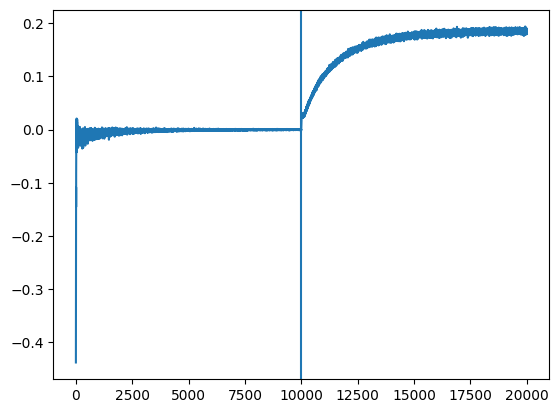

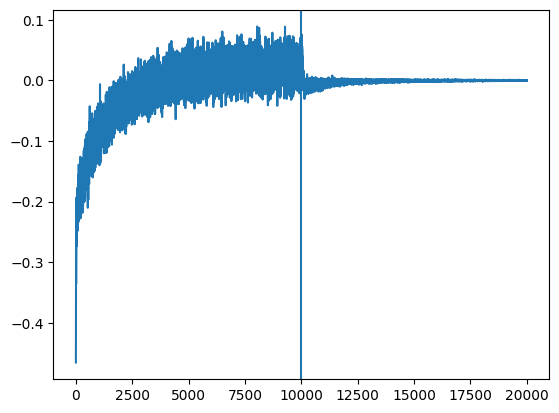

In [3]:
a = np.array(res1, dtype=float)
b = np.array(res2, dtype=float)

plt.plot(np.mean(a, axis=1))
plt.axvline(epochs)
plt.show()

plt.plot(np.mean(b, axis=1))
plt.axvline(epochs)
plt.show()

In [4]:
from jax import random
from neural_tangents import stax
import neural_tangents as nt
import jax.numpy as jnp

init_fn, apply_fn, _ = stax.serial(
    stax.Dense(widths[0]), stax.Relu(),
    stax.Dense(1),
)

key1, key2 = random.split(random.PRNGKey(1))

_, params = init_fn(key1, input_shape=X.shape)

kernel11 = nt.empirical_ntk_fn(apply_fn)
kernel22 = nt.empirical_ntk_fn(apply_fn)
kernel21 = nt.empirical_ntk_fn(apply_fn)
kernel12 = nt.empirical_ntk_fn(apply_fn)

ntk11tg = kernel11(jnp.array(tasks[0].cpu()), None, params)
ntk22tg = kernel22(jnp.array(tasks[1].cpu()), None, params)
ntk21tg = kernel21(jnp.array(tasks[1].cpu()), jnp.array(tasks[0].cpu()), params)
ntk12tg = kernel12(jnp.array(tasks[0].cpu()), jnp.array(tasks[1].cpu()), params)

ntk11tg = torch.tensor(np.array(ntk11tg)).to(device)
ntk22tg = torch.tensor(np.array(ntk22tg)).to(device)
ntk21tg = torch.tensor(np.array(ntk21tg)).to(device)
ntk12tg = torch.tensor(np.array(ntk12tg)).to(device)


In [5]:
def compute_NTK(model,X1,X2):

    layers = [p.data for p in model.parameters()]
    act_der1 = (X1 @ layers[0].T > 0)*1.0
    act1 = (X1 @ layers[0].T) * act_der1
    act_der2 = (X2 @ layers[0].T > 0)*1.0
    act2 = (X2 @ layers[0].T) * act_der2

    ntkemp = 1/(N*784)*( (act_der1 @ layers[1].T) @ (act_der2 @ layers[1].T).T * (tasks[0] @ tasks[0].T) + act1@act2.T)
    return ntkemp

In [6]:
ntk11emp = compute_NTK(mlp,tasks[0],tasks[0])
ntk12emp = compute_NTK(mlp,tasks[0],tasks[1])
ntk22emp = compute_NTK(mlp,tasks[1],tasks[1])

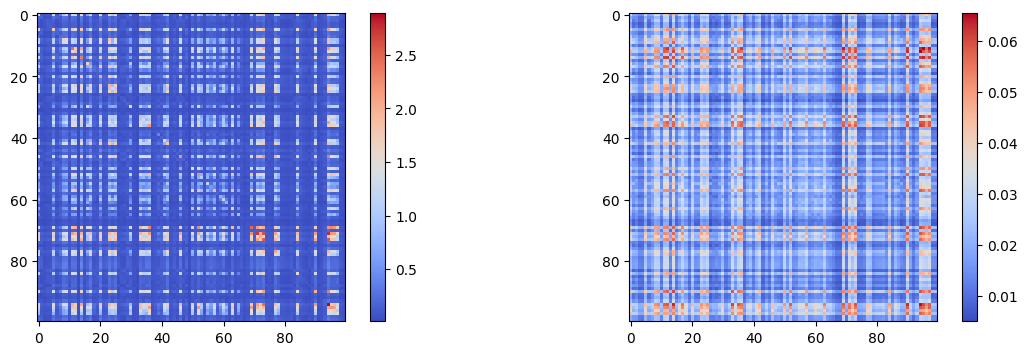

In [7]:
fig, ax = plt.subplots(1,2, figsize=(14,4))
ax0 = ax[0].imshow(ntk12emp.cpu(), cmap='coolwarm')
plt.colorbar(ax0)

ax1 = ax[1].imshow(ntk12tg.cpu(), cmap='coolwarm')
plt.colorbar(ax1)
plt.show()

In [8]:
ntk_inv = torch.linalg.inv(ntk11emp).to(device)
ntk_inv2 = torch.linalg.inv(ntk22emp).to(device)

#norm = np.sqrt(1024*2)

def delta2(t,delta10, delta20, init_mtx, ntk, ntk_mix, ntk_inv):
    ntk = torch.tensor(ntk).to('cpu')
    init_mtx = torch.tensor(init_mtx).to(device)

    term_time = init_mtx - torch.matrix_exp( -ntk*lr*t).to(device)

    d = torch.tensor(delta20, dtype=torch.float32).to(device) - ntk_mix @ ntk_inv @ term_time @ torch.tensor(delta10, dtype=torch.float32).to(device)

    return d.cpu()

def delta1(t, delta0, ntk):

    ntk = torch.tensor(ntk).to('cpu')

    term_time = torch.matrix_exp( -ntk*lr/28*t)

    d = term_time.to(device) @ torch.tensor(delta0, dtype=torch.float32).to(device)

    return np.array(d.cpu())

time = np.linspace(0,epochs,200)

d1 = np.array([])
d2 = np.array([])
d3 = np.array([])
d4 = np.array([])

for t in time:
    d1 = np.append(d1, delta1(t,a[0],ntk11emp) ) 
    d2 = np.append(d2, delta2(t,a[0],b[0], torch.eye(len(X)), ntk11emp, ntk12emp.T, ntk_inv))
    d3 = np.append(d3, delta1(t,b[epochs], ntk22emp))
    d4 = np.append(d4, delta2(t, b[epochs], a[epochs], torch.eye(len(X)), ntk22emp, ntk12emp, ntk_inv2))
    

/var/folders/bf/nxgsxk9n0xvdy1w25bwdrpg80000gn/T/ipykernel_12211/2611636102.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ntk = torch.tensor(ntk).to('cpu')
/var/folders/bf/nxgsxk9n0xvdy1w25bwdrpg80000gn/T/ipykernel_12211/2611636102.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ntk = torch.tensor(ntk).to('cpu')
/var/folders/bf/nxgsxk9n0xvdy1w25bwdrpg80000gn/T/ipykernel_12211/2611636102.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_mtx = torch.tensor(init_mtx).to(device)


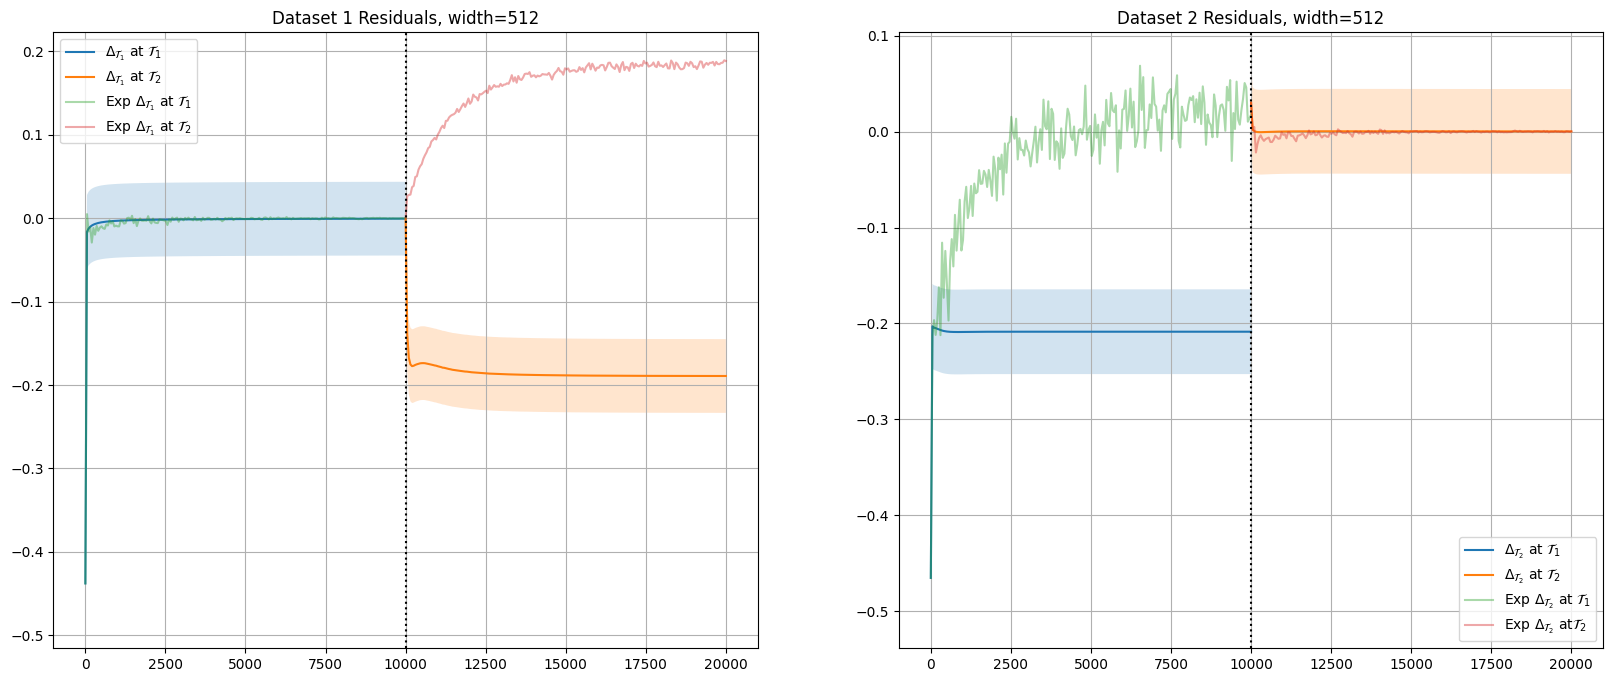

In [9]:
x1 = d1.reshape(200,batch)
x2 = d2.reshape(200,batch)
x3 = d3.reshape(200,batch)
x4 = d4.reshape(200,batch)

time2 = np.linspace(0,epochs,int(epochs/50))
time2task = np.linspace(epochs,2*epochs,200)
time2t = np.linspace(epochs,2*epochs,int(epochs/50))

fig, ax = plt.subplots(1,2, figsize=(20,8))
ax[0].plot(time,np.mean(x1,axis=1) , label='$\Delta_{\mathcal{T}_1}$ at $\mathcal{T}_1}$')
ax[0].fill_between(time, np.mean(x1,axis=1) - 1/np.sqrt(N), np.mean(x1,axis=1) + 1/np.sqrt(N), alpha=0.2)

ax[1].plot(time,np.mean(x2,axis=1) , label='$\Delta_{\mathcal{T}_2}$ at $\mathcal{T}_1}$')
ax[1].fill_between(time, np.mean(x2,axis=1) - 1/np.sqrt(N), np.mean(x2,axis=1) + 1/np.sqrt(N), alpha=0.2)

ax[1].plot(time2task,np.mean(x3,axis=1) , label='$\Delta_{\mathcal{T}_2}$ at $\mathcal{T}_2}$')
ax[1].fill_between(time2task, np.mean(x3,axis=1) - 1/np.sqrt(N), np.mean(x3,axis=1) + 1/np.sqrt(N), alpha=0.2)

ax[0].plot(time2task,np.mean(x4,axis=1) , label='$\Delta_{\mathcal{T}_1}$ at $\mathcal{T}_2}$')
ax[0].fill_between(time2task, np.mean(x4,axis=1) - 1/np.sqrt(N), np.mean(x4,axis=1) + 1/np.sqrt(N), alpha=0.2)

ax[0].plot(time2,np.mean(a[:epochs:50], axis=1) , label='Exp $\Delta_{\mathcal{T}_1}$ at $\mathcal{T}_1}$', alpha=0.4)
ax[1].plot(time2, np.mean(b[:epochs:50], axis=1), label = 'Exp $\Delta_{\mathcal{T}_2}$ at $\mathcal{T}_1}$', alpha=0.4)
ax[1].plot(time2t, np.mean(b[epochs::50], axis=1), label = 'Exp $\Delta_{\mathcal{T}_2}$ at$\mathcal{T}_2}$',  alpha=0.4)
ax[0].plot(time2t, np.mean(a[epochs::50], axis=1), label = 'Exp $\Delta_{\mathcal{T}_1}$ at $\mathcal{T}_2}$',  alpha=0.4)

ax[0].set_title(f'Dataset 1 Residuals, width={N}')
ax[1].set_title(f'Dataset 2 Residuals, width={N}')
ax[0].axvline(epochs, color='black', linestyle=':')
ax[1].axvline(epochs, color='black', linestyle=':')
ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()
#ax[0].set_xlim(epochs-1,epochs+10)
#ax[1].set_xlim(epochs-1,epochs+10)

plt.legend()
plt.show()